In [1]:
%matplotlib inline
import matplotlib.pylab as plt
import numpy as np
import pymc3 as pm

**Olasılıklı programlama** (probabilistic programming), varsayılan bir modelin parametrelerinin olasılık dağılımlarını verilere bakarak elde etme yaklaşımıdır. **Bayesci kestirim** (Bayesian inference), olasılıklı programlamanın bir alt dalını oluşturur.

Bir modelin parametrelerini kestirmek için Bayesci yaklaşım kullanmanın "klasik" istatistiksel yaklaşımlardan en önemli farkı, bize tek bir sayı kestirimi değil, bir olasılık dağılımı vermesidir. Olasılık dağılımı bize daha fazla bilgi verir ve sözgelişi güven aralıkları gibi nicelikleri hesaplamamızı da sağlar. Dahası, "klasik" yaklaşımda her türlü dağılım için kestirici bulmak mümkün olamayabilirken, Bayesci yaklaşım her tip olasılık dağılımında aynı şekilde kullanılabilir.

Daha fazla bilgi için bazı kaynaklar:
* Cameron Davidson-Pilon, ["Probabilistic Programming and Bayesian Methods for Hackers"](https://github.com/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers)
* Christopher Fonnesbeck, [Introduction to Statistical Modeling with Python](https://youtu.be/TMmSESkhRtI), PyCon 2017

İlk uygulamamız: Elimizde bazı ölçümler ($y_1, y_2\ldots, y_m$) var. Bunların bağımsız olduğunu ve aynı normal dağılımdan geldiğini düşünüyoruz, yani _modelimiz_ şöyle:

$$p(y_i\ |\ \mu,\sigma) = \frac{1}{\sqrt{2\pi\sigma^2}}\exp\left\lbrace-\frac{(y-\mu)^2}{2\sigma^2}\right\rbrace$$

$m$ tane ölçüm olduğunda , bunların birleşik olasılıkları, ölçümlerin bağımsız olduğu varsayımıyla, basitçe çarparak bulunabilir.

$$
\begin{eqnarray}
p(y_1,\ldots y_m\ |\ \mu,\sigma) &=& \prod_{i=1}^{m}\frac{1}{\sqrt{2\pi\sigma^2}}\exp\left\lbrace-\frac{(y_i-\mu)^2}{2\sigma^2}\right\rbrace \\
&=& \frac{1}{\left(2\pi\sigma^2\right)^{m/2}}\exp\left\lbrace-\frac{1}{2\sigma^2} \sum_{i=1}^m (y_i-\mu)^2 \right\rbrace 
\end{eqnarray}$$

Ama bu normal dağılımın $\mu$, $\sigma$ parametrelerini bilmiyoruz. Bayes teoremini ugulayarak bu parametrelerin sonsal dağılımını şöyle buluruz:

$$p(\mu,\sigma\ |\ y_1,\ldots y_m) = \frac{p(y_1,\ldots y_m\ |\ \mu,\sigma)p(\mu,\sigma)}{\int p(y_1,\ldots y_m\ |\ \mu,\sigma)p(\mu,\sigma) \mathrm{d}\mu \mathrm{d}\sigma} $$

Uygun bir önsel dağılım $p(\mu,\sigma)$ seçerek ve biraz matematiksel işlem yaparak bu dağılımı somut bir formüle dönüştürmek mümkün. Burada PyMC kullanmaya ilk örnek olarak bu problemi simülasyonla çözeceğiz.

## Sentetik veri

Simülasyonda kullanmak üzere, bildiğimiz parametrelerle sentetik veri üretelim.

(Not: Jupyter kod hücresinde Yunan harfi μ'yü yazmak için, `\mu` yazıp Tab tuşuna basın. Diğer harfler için de aynı yöntem geçerlidir. Python3 Unicode kullandığı için değişken isimlerinde her türlü karakter kullanılabilir.)

In [2]:
μ_gerçek = 3
σ_gerçek = 0.7
y = np.random.normal(μ_gerçek, σ_gerçek, 100)

Parametrelerin maksimum olabilirlik tahminlerine bakarak bir fikir edinelim.

In [3]:
y.mean(),y.std()

(3.0456215663643342, 0.66552397530758534)

Verilerin histogramını görelim.

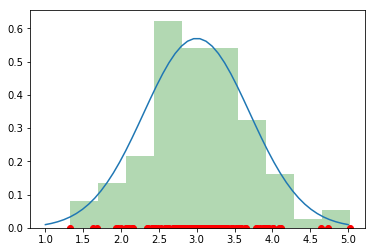

In [4]:
x = np.linspace(1,5,50)
plt.plot(x, np.exp(-(x-μ_gerçek)**2/(2*σ_gerçek**2)) / np.sqrt(2*np.pi*σ_gerçek**2))
plt.hist(y, alpha=0.3, normed=True, color="g");
plt.plot(y,np.zeros(len(y)),"ro")

## Olasılık modeli

Amacımız $y_{1:m}$ verilerini kullanarak, bunların geldiği normal dağılım parametreleri $\mu,\sigma$ hakkında tahminde bulunmak, yani $p(\mu,\sigma\ |\ y_{1:m})$ olasılık dağılımını belirlemek. Bayes formülü ile bu dağılım şu şekilde yazılabilir:

$$ \begin{eqnarray}
p(\mu,\sigma\ |\ y_{1:m}) &=& \frac{p(y_{1:m}\ |\ \mu,\sigma)p(\mu,\sigma)}{\int p(y_{1:m}\ |\ \mu,\sigma)p(\mu,\sigma) \mathrm{d}\mu \mathrm{d}\sigma}\\
&=& \frac{p(y_{1:m}\ |\ \mu,\sigma)p(\mu)p(\sigma)}{\int p(y_{1:m}\ |\ \mu,\sigma)p(\mu)p(\sigma) \mathrm{d}\mu \mathrm{d}\sigma}
\end{eqnarray}$$

İkinci adımda $\mu$ ve $\sigma$ parametrelerinin bağımsızlığını varsaydık. Ayrıca, veri noktalarının bağımsızlığından şunu da görürüz:

$$p(y_{1:m}\ |\ \mu,\sigma) = \prod_{i=1}^m p(y_i\ |\ \mu,\sigma)$$

Burada model varsayımımız gereği, olabilirlik

$$p(y_i\ |\ \mu,\sigma) = \frac{1}{\sqrt{2\pi\sigma^2}} \exp\left\lbrace-\frac{(y_i-\mu)^2}{2\sigma^2}\right\rbrace$$

olur. Önsel $p(\mu)$ ve $p(\sigma)$ olasılık dağılımlarını uygun gördüğümüz gibi seçebiliriz. Önsel olarak düzgün dağılım varsayacağız.

Böylece Bayes modelimiz şu şekilde yazılabilir:
$$\begin{eqnarray}
\mu &\sim& U(0,5) \\
\sigma &\sim& U(0,1) \\
y &\sim& N(\mu,\sigma)
\end{eqnarray}$$

In [5]:
normal_model = pm.Model()
with normal_model:
    
    # bilinmeyen model parametreleri için önseller
    ort = pm.Uniform("mu", 0,5)
    stsap = pm.Uniform("stsap", 0.6,0.8)
    
    # Gözlenen verinin olabilirliği
    Y = pm.Normal("Y", mu=ort, sd=stsap, observed=y)
    
    numuneler = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average ELBO = -105.2: 100%|██████████| 200000/200000 [00:23<00:00, 8679.69it/s] 
Finished [100%]: Average ELBO = -105.16
100%|██████████| 1000/1000 [00:02<00:00, 472.81it/s]


## Sonsal analiz

`pymc`nin Monte Carlo algoritması ile, sonsal dağılım $p(\mu,\sigma|y_{1:m})$ içinden 1000 adet numune çektik. Dağılımı hızlıca incelemek için `traceplot` komutunu kullanabiliriz.

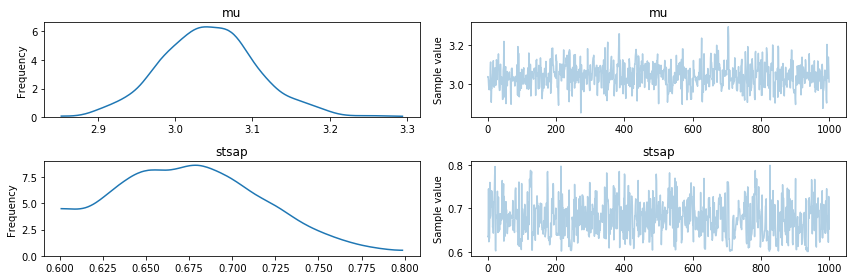

In [6]:
pm.traceplot(numuneler);

Monte Carlo simülasyonlarında başlangıçtaki adımlar her zaman rastgele olmaz, bunları atmak gerekir. PyMC algoritmaları bu sorunu büyük ölçüde gideriyor. Ama emin olmak için adımlar arasındaki ilintiye (autocorrelation) bakalım. İlintinin sıfıra yakın olması gerekir.

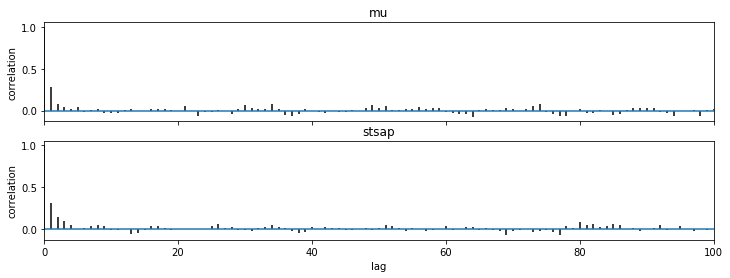

In [7]:
pm.autocorrplot(numuneler);

İncelediğimiz değişkenlere ait sonsal değerleri ve güven aralıklarını görmek için `summary()` fonksiyonunu kullanabiliriz.

In [8]:
pm.summary(numuneler)


mu:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  3.044            0.063            0.003            [2.918, 3.167]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  2.922          3.002          3.042          3.083          3.178


stsap:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  0.677            0.042            0.002            [0.601, 0.750]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  0.604          0.646          0.675          0.704          0.766



Bu verilere doğrudan ulaşabiliriz. `sample()` işlemiyle üretilen `MultiTrace` nesnesi içinde değişken bilgileri ve numune değerleri de bulunur.

Değişkenlerin isimleri `varnames` listesinde saklanır.

In [9]:
numuneler.varnames

['mu_interval_', 'stsap_interval_', 'mu', 'stsap']

Belli bir _i_ numunesindeki değişken değerlerini veren bir sözlüğe erişmek için `point()` metodu kullanılabilir.

In [10]:
numuneler.point(0)

{'mu': 3.037991640252419,
 'mu_interval_': 0.43722803047883474,
 'stsap': 0.63495452583987133,
 'stsap_interval_': -1.5521730819009387}

Belli bir değişkenin sonsal dağılımından çekilen numuneler için `get_values()` metodunu kullanabiliriz.

In [11]:
μ_sonsal = np.mean(numuneler.get_values("mu", burn=100))
σ_sonsal = np.mean(numuneler.get_values("stsap", burn=100))
μ_sonsal, σ_sonsal

(3.0455841551282155, 0.6770613054512602)

Şimdi, elde ettiğimiz sonsal parametre değerlerini orijinal veriyle ve gerçek parametrelerle karşılaştıralım.

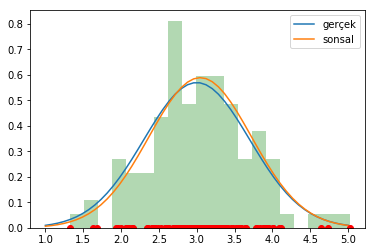

In [12]:
x = np.linspace(1,5,50)
plt.plot(x, np.exp(-(x-μ_gerçek)**2/(2*σ_gerçek**2)) / np.sqrt(2*np.pi*σ_gerçek**2), label="gerçek")
plt.plot(x, np.exp(-(x-μ_sonsal)**2/(2*σ_sonsal**2)) / np.sqrt(2*np.pi*σ_sonsal**2), label="sonsal")
plt.hist(y, bins=20, alpha=0.3, normed=True, color="g");
plt.plot(y,np.zeros(len(y)),"ro")
plt.legend();

## Çalışma

Aşağıdaki değişikliklerin sonsal tahmini nasıl değiştirdiğini inceleyin.
* `trace` fonksiyonundaki numune sayısını 10 000'e çıkarın.
* Modelin standart sapma $\sigma$ parametresi için farklı bir önsel tanımlayın, örneğin `HalfNormal`.
* Sentetik verideki nokta sayısını 400'e çıkarıp modellemeyi tekrarlayın.

## Çalışma

Amerikyum (atom sayısı 95), periyodik tablonun aktinitler dizisinde yer alan ve yapay olarak elde edilen kimyasal bir elementtir. Doğada varlığı saptanamayan amerikyum, nükleer reaksiyonların yan ürünü olarak elde edilir. Kolay elde edilebildiği için en önemli izotopu amerikyum-241'dir; bu izotop plütonyumdan elde edilmiş ve akışkan yoğunluklarının ölçümünde, kalınlık ölçmede uçak yakıtı göstergelerinde ve uzaklık algılayıcı aygıtlarda kullanılmıştır. Amerikyum-241 radyoaktiftir ve alfa parçacıkları yayarak bozunur.

Aşağıdaki verilerde bir amerikyum-241 parçasının on saniyelik aralıklar içinde kaç kere alfa parçacığı yaydığı kaydedilmiştir. ([Kaynak](www.randomservices.org/random/data/Alpha.html))

In [13]:
k = [0]*1 + [1]*4 + [2]*13 + [3]*28 + [4]*56 + [5]*105 + [6]*126 + \
[7]*146 + [8]*164 + [9]*161 + [10]*123 + [11]*101 + [12]*74 + [13]*53 + \
[14]*23 + [15]*15 + [16]*9 + [17]*3 + [18]*1 + [19]*1
k = np.array(k)
np.random.shuffle(k)

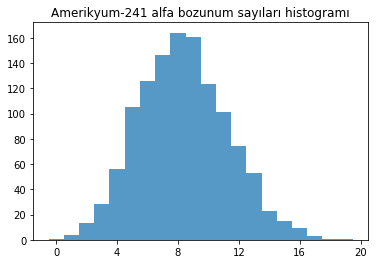

In [14]:
plt.hist(k, bins=range(21),align="left",alpha=0.75);
plt.title("Amerikyum-241 alfa bozunum sayıları histogramı")
plt.xticks(np.arange(0,21,4));

Belli bir zaman aralığı içinde $k$ alfa bozunumu gösterme olasılığı için _Poisson dağılımı_ uygun bir modeldir:

$$ p(k\ |\ \lambda) = \mathrm{e}^{-\lambda}\frac{\lambda^k}{k!}$$

Poission dağılımını çizdirmek için $\Gamma(k+1)=k!$ eşitliğinden faydalanarak Gamma fonksiyonunu kullanabiliriz.

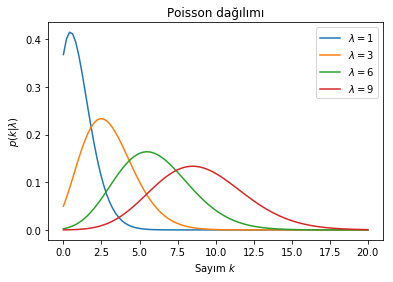

In [15]:
from scipy.special import gamma
x = np.linspace(0,20,100)
for lam in [1,3,6,9]:
    plt.plot(x, np.exp(-lam)*lam**x / gamma(x+1), label="$\lambda="+str(lam)+"$")
plt.title("Poisson dağılımı")
plt.xlabel("Sayım $k$")
plt.ylabel("$p(k|\lambda)$")
plt.legend();

Verilen $k_1\ldots k_{1207}$ sayımlarını kullanarak, bilinmeyen $\lambda$ parametresi için bir sonsal dağılım elde edin.